# **FINE TUNING FASTER RCNN USING PYTORCH**

ir5 700 imgs

In this Notebook we can fine tune a Faster RCNN on the images dataset. If you want to brush up about what is Faster RCNN, [here's](https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) an awesome medium article on the same.

Ref: inspired by the Pytorch docs tutorial [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


## Installs and Imports

Since a lot of code for object detection is same and has to be rewritten by everyone, torchvision contributers have provided us with helper codes for training, evaluation and transformations.

Let's clone the repo and copy the libraries into working directory

In [4]:
%%bash
pwd
# Download TorchVision repo to use some files from references/detection
cd /notebooks
mkdir -p pytorchvision
cd pytorchvision
git clone https://github.com/pytorch/vision.git
##!git checkout v0.3.0
cp vision/references/detection/utils.py ./
cp vision/references/detection/transforms.py ./
cp vision/references/detection/coco_eval.py ./
cp vision/references/detection/engine.py ./
cp vision/references/detection/coco_utils.py ./
cd /notebooks/ml639a/639d/
pwd

/notebooks/ml639a/639d


fatal: destination path 'vision' already exists and is not an empty directory.


/notebooks/ml639a/639d


In [10]:
%%bash
pwd
apt update
DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv
apt-get install -y libgl1-mesa-dev # libgl1-mesa-glx
pip install opencv-python-headless 
pip install opencv-python==4.5.5.64

/notebooks/ml639a/639d


Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.3 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2420 kB]
Get:7 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages [1437 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1161 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports/main amd64 Packages [54.2 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-backports/universe amd64 Packages [27.1 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:12 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1339 kB]
Get:13 http://secu

In [13]:
pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 60.5 MB 21.0 MB/s eta 0:00:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.6.0.66
    Uninstalling opencv-python-4.6.0.66:
      Successfully uninstalled opencv-python-4.6.0.66
Note: you may need to restart the kernel to use updated packages.


In [13]:
#pip install pycocotools 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install  albumentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [16]:
pip list

Package                       Version
----------------------------- -------------------------
absl-py                       1.0.0
alabaster                     0.7.12
albumentations                1.2.0
anyio                         3.5.0
apex                          0.1
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
attrs                         18.2.0
audioread                     2.1.9
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.10.0
black                         22.1.0
bleach                        4.1.0
blis                          0.7.5
brotlipy                      0.7.0
cachetools                    5.0.0
catalogue                     2.0.6
certifi                       2021.10.8
cffi                          1.15.0
chardet                       4.0.0
charset-normalizer            2.0

In [5]:
conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
absl-py                   1.0.0                    pypi_0    pypi
albumentations            1.1.0                    pypi_0    pypi
argcomplete               1.12.3                   pypi_0    pypi
argon2-cffi               21.1.0                   pypi_0    pypi
attrs                     21.2.0                   pypi_0    pypi
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.10.0             pyh06a4308_0  
blas                      1.0                         mkl  
bleach                    4.1.0                    pypi_0    pypi
blis                      0.7.5                    pypi_0    pypi
boto3                     1.20.4                   pypi_0    pypi
botocore                  1.23.4                   pypi_0    p

In [5]:
conda env list

# conda environments:
#
base                  *  /opt/conda


Note: you may need to restart the kernel to use updated packages.


Lets import the libraries

In [148]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2
from PIL import Image

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [149]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  166183 KB |    2435 MB |     890 GB |     889 GB |
|       from large pool |  146492 KB |    2337 MB |     871 GB |     871 GB |
|       from small pool |   19691 KB |     121 MB |      18 GB |      18 GB |
|---------------------------------------------------------------------------|
| Active memory         |  166183 KB |    2435 MB |     890 GB |     889 GB |
|       from large pool |  146492 KB |    2337 MB |     871 GB |

## Dataset 

In [150]:
rm ../../imgdata/inrm5/trainval/inner_rim_220429T002418.*

rm: cannot remove '../../imgdata/inrm5/trainval/inner_rim_220429T002418.*': No such file or directory


In [151]:
%%bash
array2=( 
inner_rim_210805T132302
)  
# for a in "${array2[@]}" ; do  rm ../../imgdata/inrm5/trainval/${a}* ; done 


In [152]:
# Settings:

!pwd

# use to test that training functions..
# files_dir = '../ir4/trainval/'
# test_dir = '../ir4/test/'

files_dir = '../../imgdata/inrm5/trainval/'
test_dir  = '../../imgdata/inrm5/test/'


setwidth = 260
#setheight = 7990 actual give assertionerror. 7500 works.
setheight = 7500

num_classes = 3

test_split = 0.7

num_epochs = 50

# reminders...

img_file_suffix = 'edit below'

setclasses = "edit below  self.classes = [_, 'Chip']"




/notebooks/ml639a/639d


# Inspect one image..

In [153]:
imgs = [image for image in sorted(os.listdir(files_dir))
                    if image[-4:]=='.png']

img_name = imgs[4]
image_path = os.path.join(files_dir, img_name)

# reading the images and converting them to correct size and color    
import cv2
img = cv2.imread(image_path)
imgp = Image.open(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
#img_res = cv2.resize(img_rgb, (width, height), cv2.INTER_AREA)
# diving by 255
# img_res /= 255.0

print( img.shape)
print( imgp.format)
print( image_path)


(7990, 260, 3)
PNG
../../imgdata/inrm5/trainval/inner_rim_210805T104036.png


Lets build the images dataset

In [175]:
# defining the files directory and testing directory
# files_dir = '../cast04c/train'
# test_dir = '../cast04c/test'
# files_dir = '../imgdata/sg/s1out/train/'
# test_dir = '../imgdata/sg/s1out/test/'


class AaImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        print(self.transforms)
        # classes: 0 index is reserved for background
        self.classes = [_, 'Chip', 'Crack']
        # print(idx,':',img_name)
        
    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        imgp = Image.open(image_path)
        #print(idx, imgp.format)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        #target["image_name"] = img_name

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
        
        #return img_res, target
        # if testing after model generation, return the image name. Comment above, uncoment below.
        return img_res, target, img_name
        

    def __len__(self):
        return len(self.imgs)


In [176]:

# check dataset
dataset = AaImagesDataset(files_dir, setwidth, setheight, transforms= get_transform(train=True))
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[9]
print(img.shape, '\n',target, dataset[9])

Compose([
  HorizontalFlip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
length of dataset =  310 



ValueError: too many values to unpack (expected 2)

Points to be noted -
1. The dataset returns a tuple. The first element is the image shape and the second element is a dictionary.
2. The image is of the size, we provided while defining the dataset and the color mode is RGB.
3. There are four bounding boxes in the image which is evident from four lists in boxes and length of labels.

And its done! 

Dataset building is one of the hardest things in the notebook. If you got till here while understand all of the above, you are doing pretty good!

Let's now see, what our data looks like. The function is inspired from [here](https://www.kaggle.com/kiwifairy/visualize-x-ray-image-with-bounding-boxes)

# Dataset Visualization

TypeError: Invalid shape (3, 7500, 260) for image data

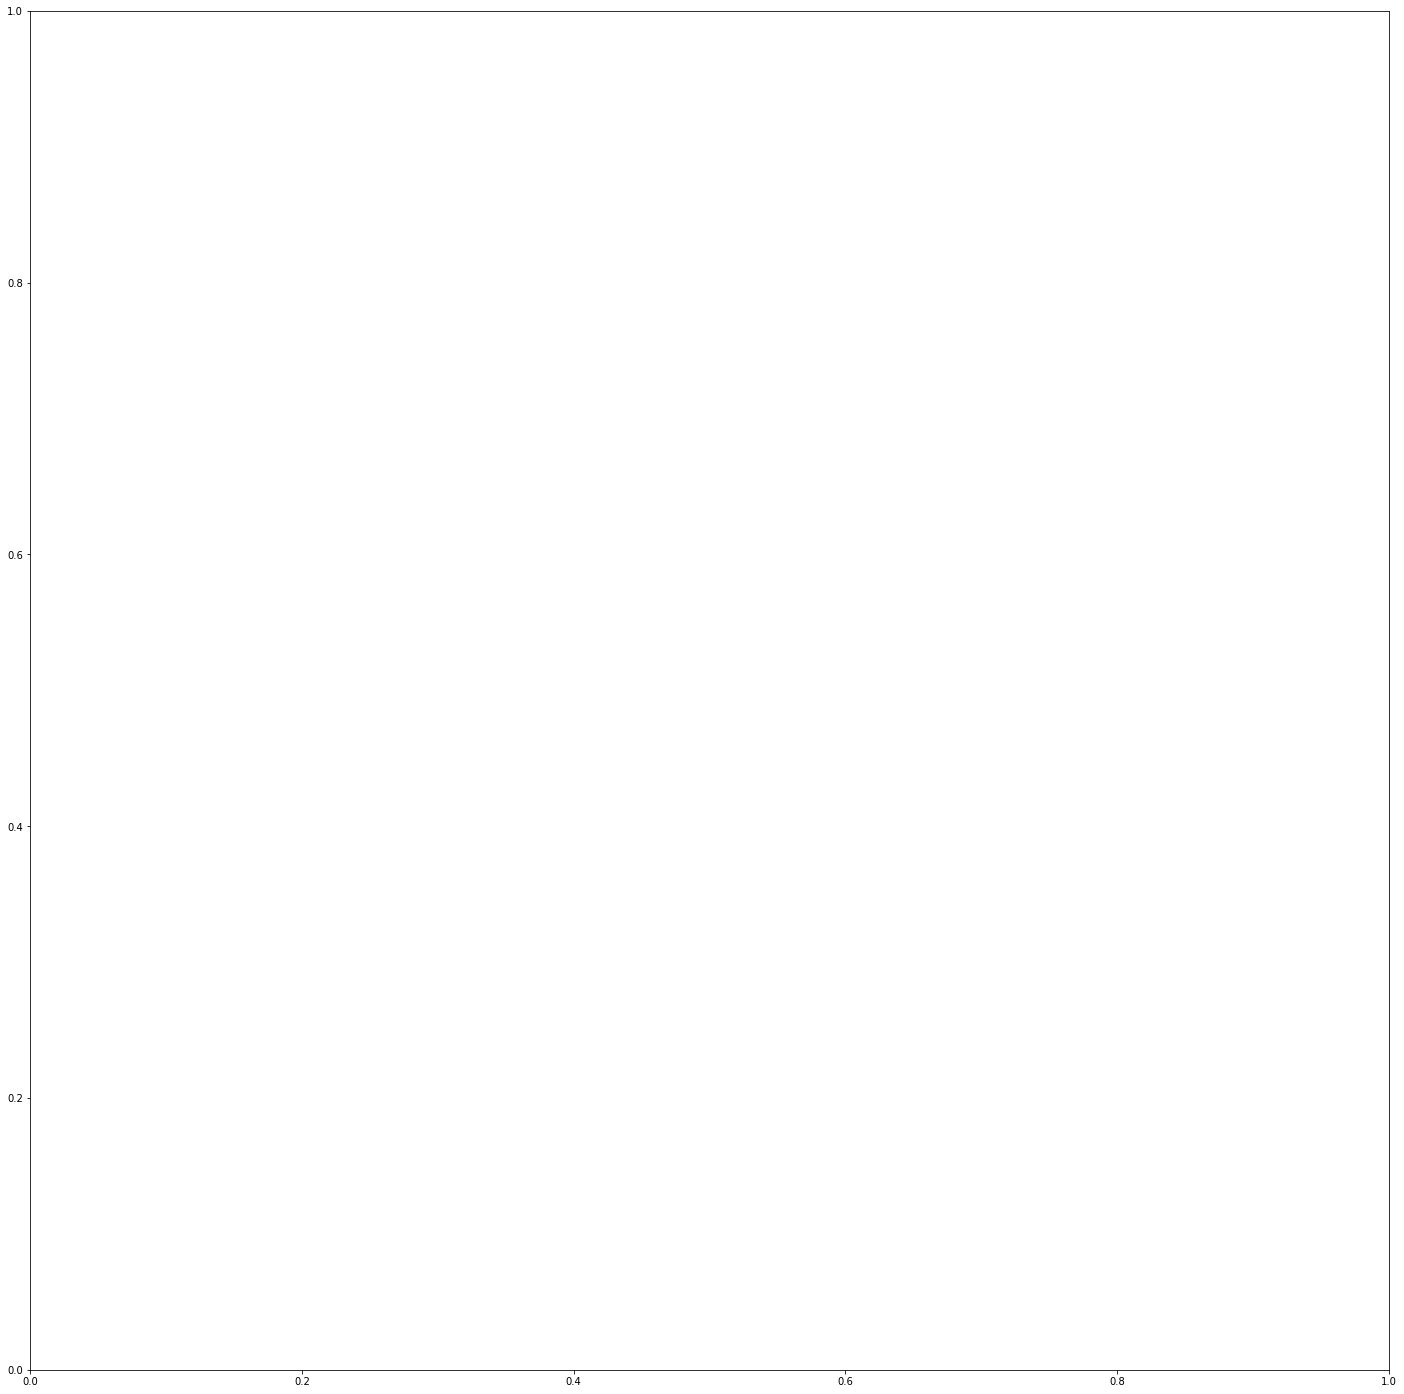

In [158]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(25,25)
    a.imshow(img)
    for box in ((target['boxes']).cpu()):
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[1]
plot_img_bbox(img, target)
print("img:",img,"targ:",target)

You can see that we are doing great till now, as the bbox is correctly placed. 

Lets build the model then!

# Prep Model

We will define a function for loading the model. We will call it later

In [159]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

You can clearly see, how easy it is to load and prepare the model using pytorch

# Dataset Augmentations

This is where we can apply augmentations to the image. 

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here I have added random flip transform, feel free to customize it as you feel



In [160]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

Now lets prepare datasets and dataloaders for training and testing.

In [161]:
# use our dataset and defined transformations
dataset = AaImagesDataset(files_dir,  setwidth, setheight, transforms= get_transform(train=True))
dataset_test = AaImagesDataset(files_dir, setwidth, setheight, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split is edited above in settings.

tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Compose([
  HorizontalFlip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
Compose([
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})


# Training Prep

Let's prepare the model for training

In [162]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# num_classes = edited above in settings

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Let the training begin!

In [163]:
# !export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

# Run the training.......

In [164]:
# training for 10 epochs

# edit me..
#num_epochs = 3

# !export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128
torch.cuda.empty_cache()
    
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
print('reached.end.')

Epoch: [0]  [ 0/10]  eta: 0:01:30  lr: 0.000560  loss: 1.5000 (1.5000)  loss_classifier: 1.2401 (1.2401)  loss_box_reg: 0.0700 (0.0700)  loss_objectness: 0.1755 (0.1755)  loss_rpn_box_reg: 0.0144 (0.0144)  time: 9.0874  data: 7.9358  max mem: 2435
Epoch: [0]  [ 9/10]  eta: 0:00:01  lr: 0.005000  loss: 0.5227 (0.7354)  loss_classifier: 0.2986 (0.4862)  loss_box_reg: 0.1108 (0.1256)  loss_objectness: 0.1050 (0.1066)  loss_rpn_box_reg: 0.0144 (0.0170)  time: 1.5844  data: 0.9852  max mem: 2435
Epoch: [0] Total time: 0:00:15 (1.5950 s / it)
creating index...
index created!
Test:  [ 0/22]  eta: 0:02:05  model_time: 0.5030 (0.5030)  evaluator_time: 0.0145 (0.0145)  time: 5.7002  data: 5.1010  max mem: 2435
Test:  [21/22]  eta: 0:00:01  model_time: 0.2652 (0.2707)  evaluator_time: 0.0082 (0.0096)  time: 0.8820  data: 0.5373  max mem: 2435
Test: Total time: 0:00:23 (1.0811 s / it)
Averaged stats: model_time: 0.2652 (0.2707)  evaluator_time: 0.0082 (0.0096)
Accumulating evaluation results...
DO


# Comments

An AP of 0.78-0.80 is not bad but perhaps we can make it even better with more augmentations, I will leave that to you.

In [ ]:
model.save()

# Decode predictions

Our model predicts a lot of bounding boxes per image, to take out the overlapping ones, We will use **Non Max Suppression** if you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply nms to our predictions, lets build a function `apply_nms` using that.

In [177]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Generated/trained Model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [182]:
# pick one image from the test set
test_dataset = AaImagesDataset(test_dir,  setwidth, setheight, transforms= get_transform(train=True))
img, target, iname  = test_dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('real #boxes: ', len(target['labels']))
print('predicted #boxes: ', len(prediction['labels']),iname)


Compose([
  HorizontalFlip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
real #boxes:  1
predicted #boxes:  11 inner_rim_210805T104545.png


Whoa! Thats a lot of bboxes. Lets plot them and check what did it predict

EXPECTED OUTPUT
tensor([ 135.0000, 2092.3030,  258.0000, 2211.5144])


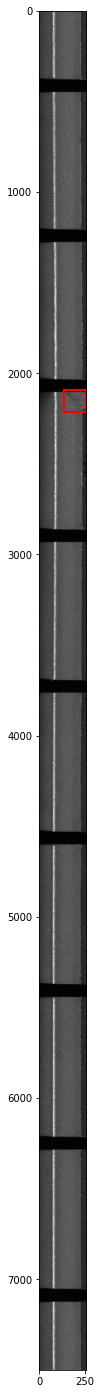

In [183]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT
tensor([  75.8573, 2125.2246,  249.3415, 2342.1511])
tensor([  83.7820, 2150.6870,  257.7546, 2254.2996])
tensor([  88.3062, 2186.8162,  259.3138, 2293.4814])
tensor([  72.5710, 2122.1375,  222.8497, 2226.4312])
tensor([ 100.8545, 2109.2656,  230.2553, 2475.4189])
tensor([ 110.9550, 2040.9602,  222.2503, 2319.3950])
tensor([  90.0306, 2228.9634,  260.0000, 2321.0388])
tensor([  96.8087, 2097.1626,  258.9337, 2286.6279])
tensor([ 106.8907, 2110.0789,  259.3854, 2194.1775])
tensor([  91.9190, 2186.8345,  257.8125, 2296.6399])
tensor([ 102.5665, 2074.0176,  229.8511, 2417.3218])


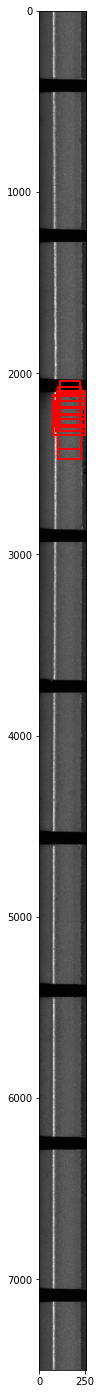

In [184]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output

NMS APPLIED MODEL OUTPUT
tensor([  75.8573, 2125.2246,  249.3415, 2342.1511])


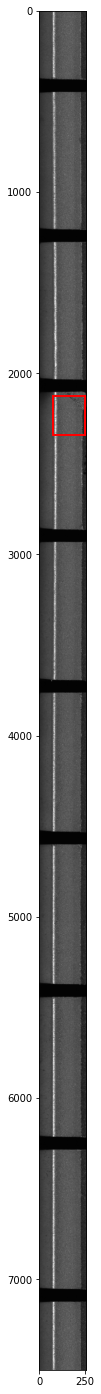

In [185]:
nms_prediction = apply_nms(prediction, iou_thresh=0.1)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Now lets take an image from the test set and try to predict on it

In [186]:
test_dataset = AaImagesDataset(test_dir,  setwidth, setheight, transforms= get_transform(train=True))
vl = len(test_dataset)
for x in range(vl):
    img, target, iname  = test_dataset[x]
    #print('real #boxes: ', len(target['labels']))
    print(x,'boxes: ', (target['labels']),iname)

Compose([
  HorizontalFlip(always_apply=0.5, p=0.5),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})
0 boxes:  tensor([1]) inner_rim_210805T104008.png
1 boxes:  tensor([1]) inner_rim_210805T104545.png
2 boxes:  tensor([1]) inner_rim_210805T105358.png
3 boxes:  tensor([1]) inner_rim_210805T105734.png
4 boxes:  tensor([1]) inner_rim_210805T110017.png
5 boxes:  tensor([1]) inner_rim_210805T125648.png
6 boxes:  tensor([1]) inner_rim_210805T130311.png
7 boxes:  tensor([2]) inner_rim_210805T130406.png
8 boxes:  tensor([1]) inner_rim_210805T130500.png
9 boxes:  tensor([1]) inner_rim_210805T130726.png
10 boxes:  tensor([2]) inner_rim_210805T131156.png
11 boxes:  tensor([1]) inner_rim_210805T131309.png
12 boxes:  tensor([1]) inner_rim_210805T131524.png
13 boxes:  tensor([1]) inner_rim_210805T1

In [187]:
print(test_dataset[41])


(tensor([[[0.0982, 0.1007, 0.1082,  ..., 0.0158, 0.0157, 0.0122],
         [0.1017, 0.0995, 0.1050,  ..., 0.0179, 0.0168, 0.0154],
         [0.1016, 0.1043, 0.1048,  ..., 0.0154, 0.0182, 0.0129],
         ...,
         [0.1065, 0.1142, 0.1152,  ..., 0.0142, 0.0132, 0.0154],
         [0.1027, 0.1083, 0.1166,  ..., 0.0142, 0.0154, 0.0157],
         [0.1096, 0.1115, 0.1191,  ..., 0.0133, 0.0148, 0.0122]],

        [[0.0982, 0.1007, 0.1082,  ..., 0.0158, 0.0157, 0.0122],
         [0.1017, 0.0995, 0.1050,  ..., 0.0179, 0.0168, 0.0154],
         [0.1016, 0.1043, 0.1048,  ..., 0.0154, 0.0182, 0.0129],
         ...,
         [0.1065, 0.1142, 0.1152,  ..., 0.0142, 0.0132, 0.0154],
         [0.1027, 0.1083, 0.1166,  ..., 0.0142, 0.0154, 0.0157],
         [0.1096, 0.1115, 0.1191,  ..., 0.0133, 0.0148, 0.0122]],

        [[0.0982, 0.1007, 0.1082,  ..., 0.0158, 0.0157, 0.0122],
         [0.1017, 0.0995, 0.1050,  ..., 0.0179, 0.0168, 0.0154],
         [0.1016, 0.1043, 0.1048,  ..., 0.0154, 0.0182, 0

In [188]:
## !pwd
# 
imts = [15,19,30,39]
imts = [39]
imts = range(58)

for x in imts:
    img, target, iname  = test_dataset[x]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    #print(target['labels'])
    #print('MODEL OUTPUT')
    nms_prediction = apply_nms(prediction, iou_thresh=0.3)
    #plot_img_bbox(torch_to_pil(img), nms_prediction)
    print(x,'EXPECTED: ',target['labels'],'MODEL: ', prediction['labels'],iname  )
    #print('predicted #boxes: ', (prediction))

0 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1, 1], device='cuda:0') inner_rim_210805T104008.png
1 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1], device='cuda:0') inner_rim_210805T104545.png
2 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1, 1], device='cuda:0') inner_rim_210805T105358.png
3 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1], device='cuda:0') inner_rim_210805T105734.png
4 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1], device='cuda:0') inner_rim_210805T110017.png
5 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1, 1], device='cuda:0') inner_rim_210805T125648.png
6 EXPECTED:  tensor([1]) MODEL:  tensor([1], device='cuda:0') inner_rim_210805T130311.png
7 EXPECTED:  tensor([2]) MODEL:  tensor([], device='cuda:0', dtype=torch.int64) inner_rim_210805T130406.png
8 EXPECTED:  tensor([1]) MODEL:  tensor([1, 1], device='cuda:0') inner_rim_210805T130500.png
9 EXPECTED:  tensor([1]) MODEL:  tensor([1], device='cuda:0') inner_rim_210805T130726.png
10 EXPECTED:  tensor([2]) MODEL:  tensor([], device=

EXPECTED OUTPUT inner_rim_220511T094831.png
tensor([122.2000,  35.6696, 180.2667, 132.3529])
tensor([104.0000, 115.4568, 131.7333, 181.1640])
tensor([ 91.0000, 164.2678, 108.3333, 341.6771])


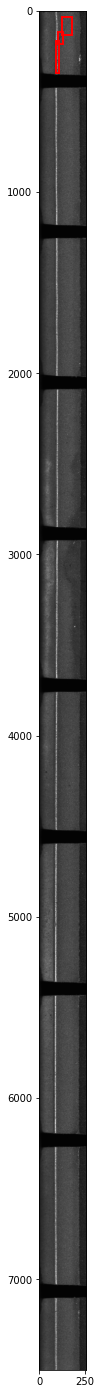

MODEL OUTPUT
tensor([ 75.9820,  25.9061, 199.8809, 350.3955])
tensor([  85.0534, 3017.4512,  197.6252, 3399.1753])
tensor([  67.2458, 3120.1477,  220.4947, 3225.4243])
tensor([ 88.1135, 166.4751, 260.0000, 250.8953])


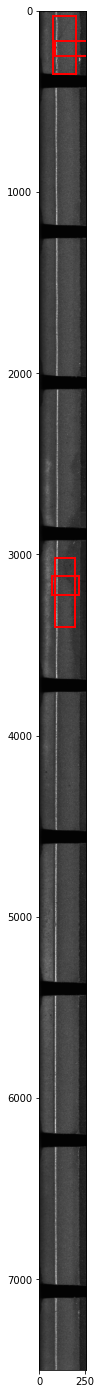

In [189]:
## !pwd
# with images
imts = [15,19,30,39]
imts = [55]

for x in imts:
    img, target, iname  = test_dataset[x]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    print('EXPECTED OUTPUT', iname )
    plot_img_bbox(torch_to_pil(img), target )
    print('MODEL OUTPUT')
    nms_prediction = apply_nms(prediction, iou_thresh=0.3)
    plot_img_bbox(torch_to_pil(img), nms_prediction)

The model did predict a void even though it was a small amount of image data and a simple short training.

But fear not, this is just a base line model here are some ideas we can improve it - 
1. Use a better model. 
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out. 

# Fin.

That's it for the notebook. 
